In [1]:
!pip install sktime

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
os.chdir("/content/drive/MyDrive/Datasets")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.utils.plotting import plot_series

In [27]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/BUNDESBANK-BBK01_WT5511.csv",index_col=0)
idx = pd.to_datetime( df.index, dayfirst=True ).to_period("M")
df.index = idx

In [28]:
y_train, y_test = temporal_train_test_split(df,test_size=6)

In [29]:
y_train.shape

(571, 1)

In [30]:
y_test.shape

(6, 1)

In [31]:
fh = np.arange(1, len(y_test) + 1)  # forecasting horizon
fh

array([1, 2, 3, 4, 5, 6])

In [32]:
regressor = RandomForestRegressor(random_state=23)

In [ ]:
forecaster = make_reduction(regressor,window_length=7)
forecaster

In [34]:
forecaster.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=23),
                                     window_length=7)

In [35]:
y_pred = forecaster.predict(fh)
rmse = MeanSquaredError(square_root=True)
print(rmse(y_test, y_pred))

88.9346408045911


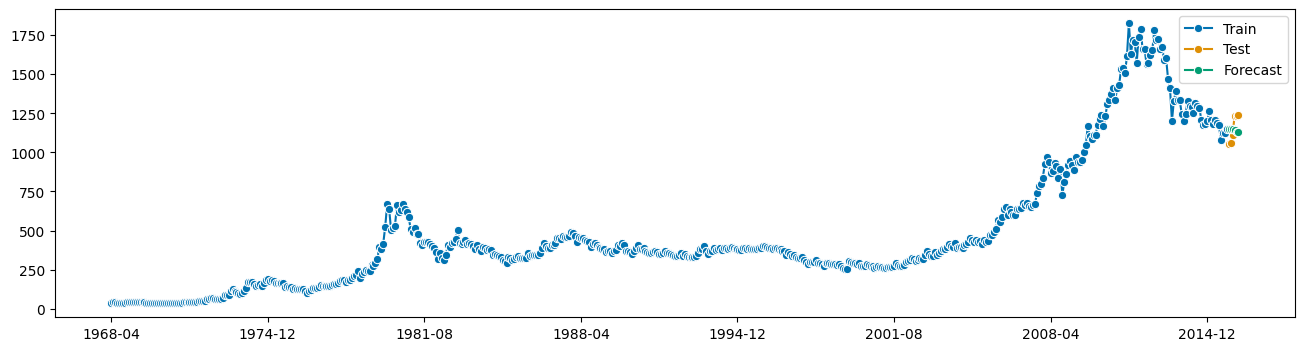

In [36]:
plot_series(y_train,y_test,y_pred , labels=['Train','Test','Forecast'])
plt.show()

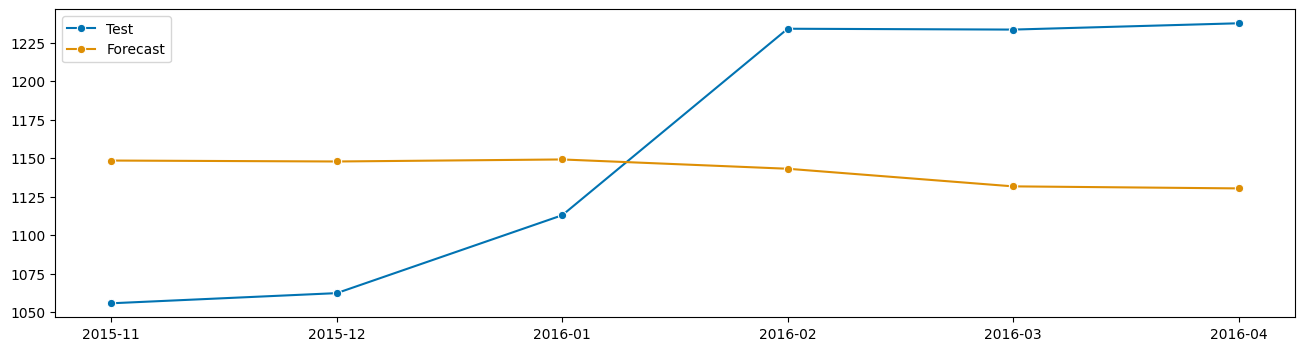

In [37]:
plot_series(y_test,y_pred , labels=['Test','Forecast'])
plt.show()

**Basic Grid Search**

In [38]:
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

In [39]:
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [6,7,8,9,10]}

We fit the forecaster on an initial window which is 80% of the historical data
then use temporal sliding window cross-validation to find the optimal hyper-parameters


In [40]:
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

In [41]:
gscv.fit(y_train)

/usr/local/lib/python3.10/dist-packages/sktime/forecasting/model_selection/_tune.py:198: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(


ForecastingGridSearchCV(cv=SlidingWindowSplitter(initial_window=456,
                                                 window_length=20),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=23),
                                                                        window_length=15),
                        param_grid={'window_length': [6, 7, 8, 9, 10]})

In [42]:
print(gscv.best_params_)

{'window_length': 6}


In [43]:
print(np.sqrt(gscv.best_score_))

0.22564365360476588


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

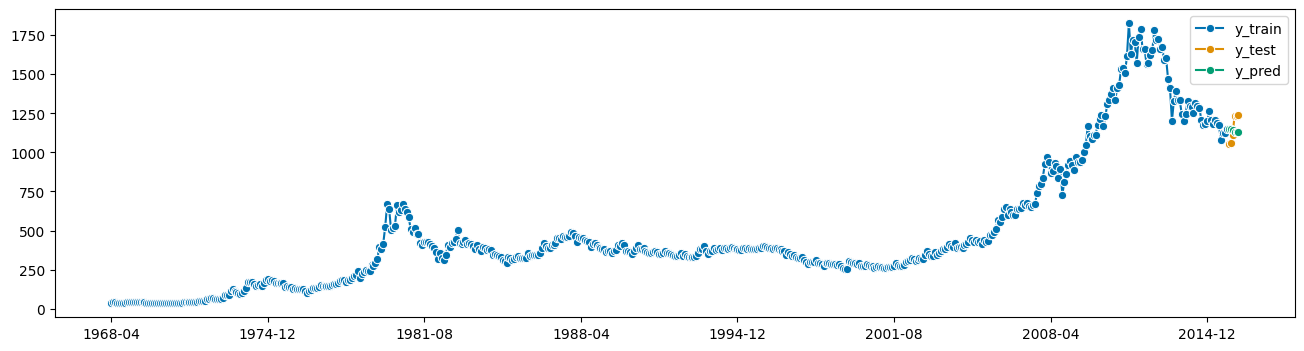

In [44]:
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [45]:
print(rmse(y_test, y_pred))

91.16711706325368


**Composite Grid Search**

In [46]:
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [6,7,8,9,10],
              'estimator__max_features':[2,3,4,5]}
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cv, param_grid=param_grid)

In [47]:
gscv.fit(y_train)

/usr/local/lib/python3.10/dist-packages/sktime/forecasting/model_selection/_tune.py:198: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(


ForecastingGridSearchCV(cv=SlidingWindowSplitter(initial_window=456,
                                                 window_length=20),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=23),
                                                                        window_length=15),
                        param_grid={'estimator__max_features': [2, 3, 4, 5],
                                    'window_length': [6, 7, 8, 9, 10]})

In [48]:
print(gscv.best_params_)

{'estimator__max_features': 5, 'window_length': 6}


In [49]:
print(gscv.best_score_)

0.050665031023722294


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

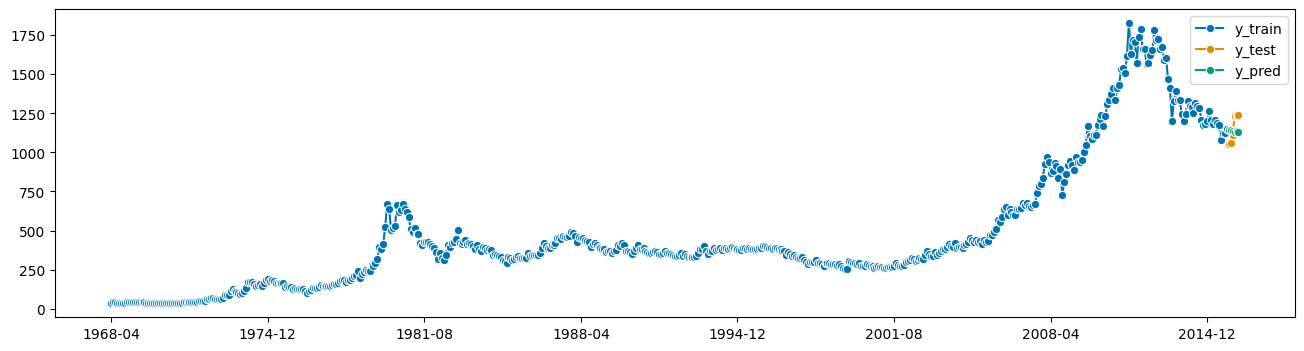

In [50]:
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()

In [51]:
print(rmse(y_test, y_pred))

87.4856737624319


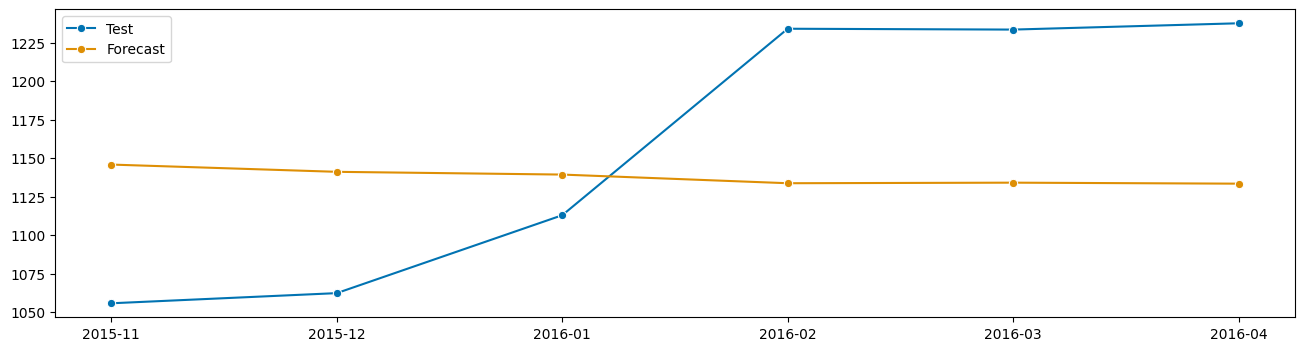

In [52]:
plot_series(y_test,y_pred , labels=['Test','Forecast'])
plt.show()